# Choosing the Classification Threshold Based on Expected Cost
This code contains to parts. 
* Illustration of how $p_{threshold}$ is determined in a classification with different costs for false positives and false negatives, assuming a perfectly calibrated probabilistic classifier.
* Illustration of how classification threshold can be set empirically on a validation set.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, confusion_matrix

## Minimizing Expected Cost with Calibrated p
This part is to illustrate the principles explained in the behind *Minimizing Expected Cost*. 

In [3]:
# Function to visualise cost components for a perfectly calibrated probabilistic classifier
# and to compute optimal p_threshold.
def plot_cost_components(C_FP, C_FN):
    p_values = np.linspace(0, 1, 1000)  # Probability values from 0 to 1
    
    # False Positive Cost (if classified as positive)
    FP_costs = C_FP * (1 - p_values)
    
    # False Negative Cost (if classified as negative)
    FN_costs = C_FN * p_values
    
    # Total expected cost for different decision thresholds
    total_costs = np.minimum(FP_costs, FN_costs)
    
    # Optimal threshold: where FP_cost = FN_cost
    optimal_threshold_index = np.argmin(np.abs(FP_costs - FN_costs))
    optimal_p = p_values[optimal_threshold_index]
    
    # Theoretically computed threshold
    theoretical_p = C_FP / (C_FP + C_FN)
    
    # Plot the costs
    plt.figure(figsize=(8, 6))
    plt.plot(p_values, total_costs, label="E[Cost], optimal classification c", linewidth=5, color='blue')
    plt.plot(p_values, FP_costs, label="E[Cost], classification=1", linestyle='-', linewidth=2, color='red')
    plt.plot(p_values, FN_costs, label="E[Cost], classification=0", linestyle='-', linewidth=2, color='lightgreen')
    
    
    # Mark optimal threshold on plot
    plt.axvline(optimal_p, color='red', linestyle='--', label=f"Empirical Optimal p = {optimal_p:.2f}")
    plt.axvline(theoretical_p, color='purple', linestyle=':', label=f"Theoretical p = {theoretical_p:.2f}")
    
    plt.xlabel("Probability p")
    plt.ylabel("E[Cost]    ( = Expected Cost)")
    plt.title("Cost Components and Optimal Threshold for a Calibrated Classifier")
    plt.legend()
    plt.show()
    
    print(f"Empirical optimal threshold (from cost analysis): {optimal_p:.4f}")
    print(f"Theoretical threshold (from formula p_threshold =  C_FP / (C_FP + C_FN)): {theoretical_p:.4f}")

## Assignment
Run the function `plot_cost_components(C_FP, C_FN)` (see following cell). Experiment with some different cost values. Make sure that you understand how the threshold $p_{\text{threshold}}$ is  calculated and what it optimizes. Also make sure that you understand the meaning of the different lines (blue, red, green, red-dashed, purple dotted) in the figure and how they relate with the costs, the threshold $p_{\text{threshold}}$ and the classification rule : classify as negative if $p<p_{\text{threshold}}$ and as positive if $p>p_{\text{threshold}}$.

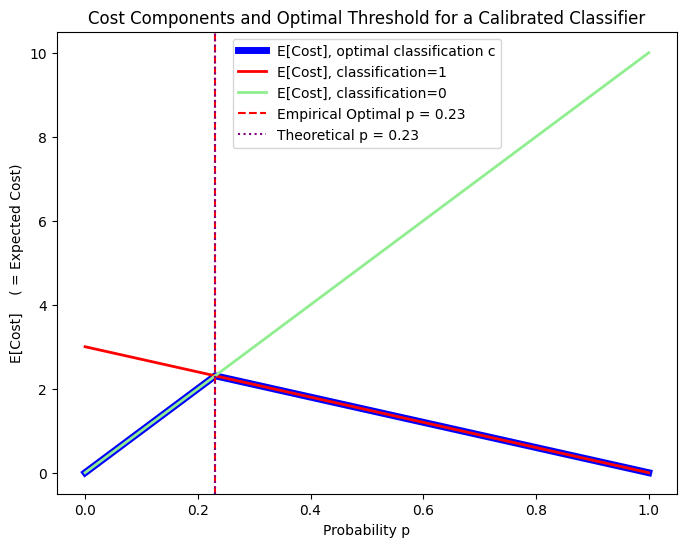

Empirical optimal threshold (from cost analysis): 0.2312
Theoretical threshold (from formula p_threshold =  C_FP / (C_FP + C_FN)): 0.2308


In [4]:
# Example usage
C_FP = 3  # Cost of a false positive
C_FN = 10
# Cost of a false negative
plot_cost_components(C_FP, C_FN)


## Empirical Cost-Based Thresholding

We train a SGDClassifier, a logistic regression model and a random forest classifier on G\'eron's  MNIST dataset example  in which the task is to identify whether a given digit  is a '5' (positive class) or not (negative class). The logistic regression model and a random forest classifier both have probability estimates as output, these will be used as 'scores'. The SGDClassifier outputs 'scores' that are not directly interpretable as probabilities. Using cross-validation, out-of-sample scores `y_score` of all instances are generated for each of the models. 

With a routine  called `binary_clf_curve(y_true, y_score)`, we compute for all possible thresholds $s$ and the values  $TP(s), FP(s), FN(s)$ that would be obtained if that threshold was selected.  

This routine is called by the  routine `empirical_costbased_thresholding`. This latter routine illustrates the process of Empirical Cost-Based Thresholding. Given `y_true, y_score` and values of $C_{FP}/C_{FN}$, the routine computes and plots for all relevant thresholds $s$ the costs \( C(s) = C_{FP} \cdot FP(s) + C_{FN} \cdot FN(s) \) and computes the optimal threshold $s_{\text{threshold}}$ as well as the costs, precision and recall with this threshold. Furthermore, if $s$ is probability like, (so it make sense to denote $s$ as $p$ and $s_{\text{threshold}}$  as $p_{\text{threshold}}$), the value is compared with the value that would have been obtained if $p$  was calibrated

First we load the MNIST data set 

In [5]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
X, y = mnist.data, mnist.target.astype(int)
X = X/255
# Binary classification: 5 vs. not-5
y_binary = (y == 5).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/datasets/_openml.py:109: UserWarning: A network error occurred while downloading https://api.openml.org/api/v1/json/data/list/data_name/mnist_784/limit/2/data_version/1. Retrying...
  warn(


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1020)>

Then we  train + crossvalidate the three models. Their out-of-sample scores are `scores_sgd`, `scores_logres` and `scores_rf`.  The scores `scores_logres` and `scores_rf` are probability scores.

In [5]:
sgd = SGDClassifier(random_state=42)
scores_sgd = cross_val_predict(sgd, X_train, y_train, cv=3, method= 'decision_function')

logreg = LogisticRegression(random_state=42, max_iter=1000)
scores_logreg = cross_val_predict(logreg, X_train, y_train, cv=3, method= 'predict_proba')[:,1]

rf = RandomForestClassifier(random_state=42)
scores_rf = cross_val_predict(rf, X_train, y_train, cv=3, method= 'predict_proba')[:,1]

In [6]:
def binary_clf_curve(y_true, y_score):
    """Calculate thresholds as well as true and false positives and false negatives per threshold.

    Parameters
    ----------
    y_true : ndarray of shape (n_samples,)
        True targets of binary classification.

    y_score : ndarray of shape (n_samples,)
        Estimated probabilities or output of a decision function.


    Returns
    -------
    fps : False positives

    fns : False negatives

    thresholds : score values of thresholds, start high with all negative classification
    """
    
    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]
    

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = np.cumsum(y_true)[threshold_idxs]
    
    fps = 1 + threshold_idxs - tps
    fns = tps[-1] - tps
    thresholds = y_score[threshold_idxs]
    return tps, fps, fns, thresholds


In [7]:
# Function to illustrates the process of Empirical Cost-Based Thresholding
def empirical_costbased_thresholding(y_true, scores, model_name, C_FP, C_FN, p=False):
    """
    Illustrates Empirical Cost-Based Thresholding

    Parameters
    ----------
    scores : ndarray of shape (n_samples,)
        Predicted scores for all samples (e.g. classifier outputs or probabilities).
    model_name : str
        Name of the model, used for labeling or output purposes.
    C_FP : int or float
        Cost associated with a false positive classification.
    C_FN : int or float
        Cost associated with a false negative classification.
    p : bool, optional (default=False)
        If True, the scores are probability-like and range from 0 to 1.
        and will be compared with the theoretical 
    """
    
    
    true_positives, false_positives,  false_negatives, thresholds = binary_clf_curve(y_true, scores)
    
    total_costs = C_FP * false_positives + C_FN * false_negatives  
    
    plt.figure()
    
    plt.plot(thresholds, total_costs, marker='o',color='blue' , linestyle='-')
    plt.plot(thresholds, total_costs,  linestyle='-',color='blue', linewidth=4, label= 'Total Expected Cost')
    
    
    if(p):
        plt.xlabel("Probability Threshold")
    else:
        plt.xlabel("Threshold")
    plt.ylabel("Cost")
    plt.title(f"Cost vs. Threshold - {model_name}")
    
    min_cost_index = np.argmin(total_costs)
    optimal_threshold = thresholds[min_cost_index]
    
    plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
    plt.legend()
    plt.show()
    
    TP = true_positives[min_cost_index]
    FP = false_positives[min_cost_index]
    FN = false_negatives[min_cost_index]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
                    
    
    threshold_with_calibrated_p = C_FP/(C_FN+C_FP)
    print(f"Optimal threshold for {model_name}: {optimal_threshold:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Empirically minimized expected costs: {total_costs[min_cost_index]:.2f}")
    print(f"Empirically minimized expected costs per item: {total_costs[min_cost_index]/len(y_true):.2f}")
    
    if(p):
        print(" ")
        print(f"With calibrated p threshold would be: {threshold_with_calibrated_p:.2f}")
        index = np.searchsorted(-thresholds, -threshold_with_calibrated_p, side='right') - 1
        print(f"Expected cost with this calibrated p threshold: {total_costs[index]:.2f}")    
    
    return optimal_threshold

## Assignment
Make sure that you understand the principles behind *Cost-Based Thresholding*. 

Run the code below and experiment with some combinations of $C_{FP}$ and $C_{FN}$ to answer the following questions 

* Explain the curve of the costs $\text{Cost}(\text{threshold})$. Do you understand its value when the threshold would be minimal, or maximal, and how this changes with a different combination of $C_{FP}$ and $C_{FN}$?
* Verify that only the ratio $C_{FP}/C_{FN}$ matters for the determination of the threshold (i.e. verify that  if $\alpha > 0$, the combination $(C_{FP}, C_{FN})$ and $(\alpha C_{FP}, \alpha C_{FN})$ result in the same threshold.
* How do thresholds chance when the ratio $C_{FP}/C_{FN}$ increases, decreases?  
* In logistic regrssion and random forest compare for various combinations of $C_{FP}$ and $C_{FN}$ the threshold with the theoretically calculated threshold.  
* In which model is the threshold generally closer to the theoretically calculated threshold. Do you understand why?
* Which of the three models is the best classifier? Motivate your conclusion.
*  How do precision/recall  increase/decrease when the ratio $C_{FP}/C_{FN}$ increases, decreases? 


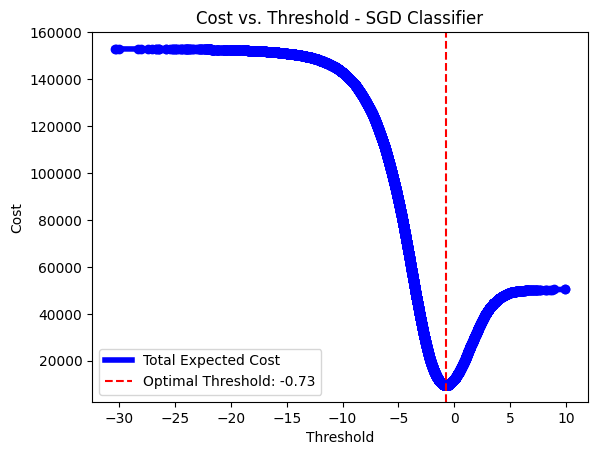

Optimal threshold for SGD Classifier: -0.73
Precision: 0.81
Recall: 0.87
Empirically minimized expected costs: 9707.00
Empirically minimized expected costs per item: 0.17


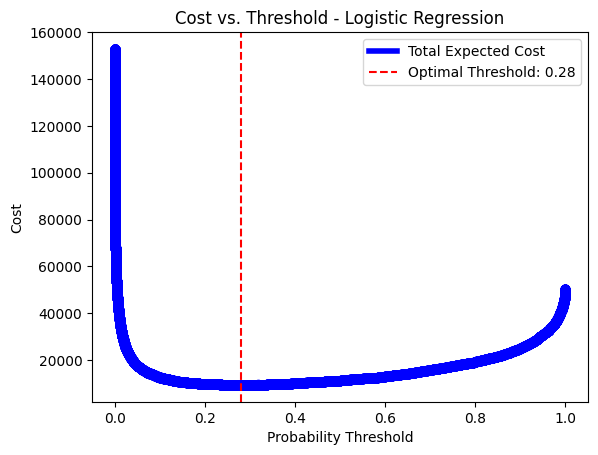

Optimal threshold for Logistic Regression: 0.28
Precision: 0.81
Recall: 0.88
Empirically minimized expected costs: 9359.00
Empirically minimized expected costs per item: 0.17
 
With calibrated p threshold would be: 0.23
Expected cost with this calibrated p threshold: 9583.00


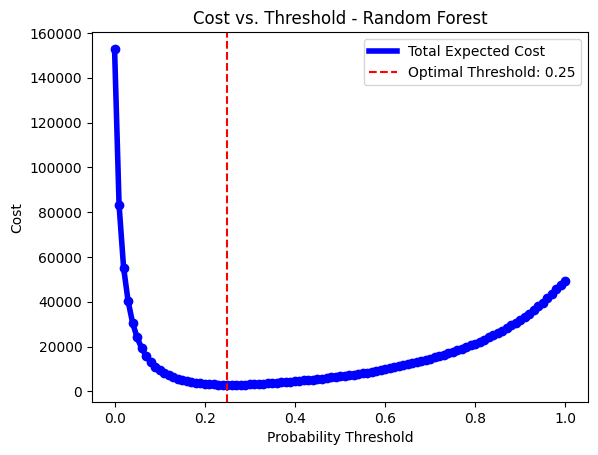

Optimal threshold for Random Forest: 0.25
Precision: 0.91
Recall: 0.97
Empirically minimized expected costs: 2865.00
Empirically minimized expected costs per item: 0.05
 
With calibrated p threshold would be: 0.23
Expected cost with this calibrated p threshold: 2905.00


In [8]:
# Define cost values
C_FP, C_FN = 3, 10  # Example: False negatives are 10 times more costly than false positives

# Compute and plot costs for all models
th_sgd = empirical_costbased_thresholding(y_train, scores_sgd, "SGD Classifier", C_FP, C_FN)
th_logreg = empirical_costbased_thresholding(y_train, scores_logreg, "Logistic Regression", C_FP, C_FN, p=True)
th_rf = empirical_costbased_thresholding(y_train, scores_rf, "Random Forest", C_FP, C_FN, p= True)

Now retrain the models on the full training set, and evaluate the average cost per sample on the test set, using the optimal threshold found earlier. Is the average cost  about the same as found earlier?

First we define the average cost function.

In [9]:
def myAveragedCosts(y_true, y_pred, C_FN, C_FP):
    score = confusion_matrix(y_true, y_pred)[1,0]*C_FN + confusion_matrix(y_true, y_pred)[0,1]*C_FP 
    return score/len(y_true)

Then retrain the models and evaluate their average costs on the test set. 

In [10]:
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.decision_function(X_test) > th_sgd
av_testscore_sgd = myAveragedCosts(y_test, y_pred_sgd, C_FN, C_FP)
print(f'sgd    Av Costs: {av_testscore_sgd:.5f}')
      
logreg.fit(X_train, y_train)
y_pred_logreg = (logreg.predict_proba(X_test)[:,1]) > th_logreg
av_testscore_logreg = myAveragedCosts(y_test, y_pred_logreg, C_FN, C_FP)
print(f'logreg Av Costs: {av_testscore_logreg:.5f}')

rf.fit(X_train, y_train)
y_pred_rf = (rf.predict_proba(X_test)[:,1]) > th_rf
av_testscore_rf = myAveragedCosts(y_test, y_pred_rf, C_FN, C_FP)
print(f'ranfor Av Costs: {av_testscore_rf:.5f}')

sgd    Av Costs: 0.16050
logreg Av Costs: 0.15700
ranfor Av Costs: 0.04329


Just to verify, is the threshold still about right, or would a lower or higher threshold have been better?

In [11]:
y_pred = (rf.predict_proba(X_test)[:,1]) > (th_rf-0.1)
costlow = myAveragedCosts(y_test, y_pred, C_FN, C_FP)
y_pred = (rf.predict_proba(X_test)[:,1]) > (th_rf+0.1)
costhigh = myAveragedCosts(y_test, y_pred, C_FN, C_FP)
print(f' Random forest cost lower threshold  : {costlow:.5f}')
print(f' Random forest cost current threshold: {av_testscore_rf:.5f}')
print(f' Random forest cost higher threshold : {costhigh:.5f}')

 Random forest cost lower threshold  : 0.06693
 Random forest cost current threshold: 0.04329
 Random forest cost higher threshold : 0.05650
